In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 14291 (delta 0), reused 2 (delta 0), pack-reused 14285
Receiving objects: 100% (14291/14291), 12.87 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (9748/9748), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [ ]:
# get yolov3 pretrained coco dataset weights
# !wget https://pjreddie.com/media/files/yolov3.weights
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2020-09-07 07:14:27--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  63.6KB/s    in 6m 0s   

2020-09-07 07:20:28 (96.1 KB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

 boxes		        inroom_tc	        test.sframe
'Colab Notebooks'      'My Drive'	       'To-do list.gsheet'
'Getting started.pdf'   objdet_tc.ipynb         Umar_aws_CP_cert.JPG
 handkeypoints	       'Pros and cons.gsheet'   yolov4


# Training a Custom YOLOv3 Object Detector in the Cloud!
Now comes the fun part! It is time to create your very own custom object detector, all within the cloud for free! The options are endless for what objects/classes you can make your detector detect. So think of something creative or just follow along with what I create. It is up to you!

**WOW! YOU ARE KILLING IT SO FAR!** 

This requires a couple tricks and tips so make sure to follow along closely with the rest of the tutorial.

In order to create a custom YOLOv3 detector we will need the following:

*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt file (test.txt is optional here as well)


# Step 2: Moving Your Custom Dataset Into Your Cloud VM
So now that you have your dataset properly formatted to be used for training we need to move it into this cloud VM so that when it comes the time we can actually use it for training.

I recommend renaming the folder with your images and text files on your local machine to be called '**obj**' and then creating a .zip folder of the 'obj' folder. Then I recommend uploading the zip to your Google Drive. So you should now have obj.zip someplace in your Google drive. 

This will **greatly reduce** the time it takes to transfer our dataset into our cloud VM.

Now we can copy in the zip and unzip it on your cloud VM.

In [ ]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/yolov4

20200830_170942.jpg  backup	       generate_train.py  obj.zip
20200830_170945.jpg  backup_y3	       obj.data		  test.zip
20200830_170954.jpg  generate_test.py  obj.names	  yolov4-obj.cfg


In [ ]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/yolov4/obj.zip ../

In [52]:
!cp /mydrive/yolov4/test.zip ../

In [51]:
cd ..

/content


In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d darknet/data/

Archive:  ../obj.zip
   creating: darknet/data/obj/
  inflating: darknet/data/obj/3183a344c115bdef.txt  
  inflating: darknet/data/obj/3a53b7ca8cf4dcac.txt  
  inflating: darknet/data/obj/7e2517637092c5e6.jpg  
  inflating: darknet/data/obj/5db5f9646e038459.jpg  
  inflating: darknet/data/obj/bdddfd390fdb631a.txt  
  inflating: darknet/data/obj/01e4e04112972131.txt  
  inflating: darknet/data/obj/14bd361f7e2d09e1.txt  
  inflating: darknet/data/obj/2a4217229dd7fac6.txt  
  inflating: darknet/data/obj/52d9d1138be3c752.txt  
  inflating: darknet/data/obj/db880bab8920e587.jpg  
  inflating: darknet/data/obj/006ce59c4a4737ec.txt  
  inflating: darknet/data/obj/f5b4b3f47b2e7d81.txt  
  inflating: darknet/data/obj/09c0b204da1e5519.txt  
  inflating: darknet/data/obj/357ef59dae92b6c8.jpg  
  inflating: darknet/data/obj/53f2663611cda24f.jpg  
  inflating: darknet/data/obj/5569724fc69793f3.txt  
  inflating: darknet/data/obj/57fa1d5ee53e8d35.txt  
  inflating: darknet/data/obj/176d679720b716ac.

In [53]:
!unzip ../test.zip -d darknet/data/

Archive:  ../test.zip
   creating: darknet/data/test/
  inflating: darknet/data/test/98ba97deb0feb657.jpg  
  inflating: darknet/data/test/ac8deac7d6702443.jpg  
  inflating: darknet/data/test/3d93458d9b114321.jpg  
  inflating: darknet/data/test/7d19c6655ae82c10.jpg  
  inflating: darknet/data/test/f187717e68a02c4b.jpg  
  inflating: darknet/data/test/6d4e234692694cd4.jpg  
  inflating: darknet/data/test/0d8806337b963d80.jpg  
  inflating: darknet/data/test/04e310af546ec9d0.jpg  
  inflating: darknet/data/test/72b13048f15f513c.jpg  
  inflating: darknet/data/test/df6dd70f7cc1aee6.jpg  
  inflating: darknet/data/test/92a0a6e90840355f.jpg  
  inflating: darknet/data/test/6be461921a2b69f1.jpg  
  inflating: darknet/data/test/eb816b440550f451.jpg  
  inflating: darknet/data/test/5cc53ecdb01c9a42.jpg  
  inflating: darknet/data/test/bfd453a9345ee0fc.jpg  
  inflating: darknet/data/test/665cac5fd1cc2186.jpg  
  inflating: darknet/data/test/fd21435721d28b95.jpg  
  inflating: darknet/data/te

# Step 3: Configuring Files for Training
This step involves properly configuring your custom .cfg file, obj.data, obj.names and train.txt file.

I have a detailed video on how to properly configure all four of these files to train a custom yolov3 detector. I will spare the time and ask you to watch the video in order to properly learn how to prepare the files.

You can access the video with this link! [Configuring YOLOv3 Files for Training](https://www.youtube.com/watch?v=zJDUhGL26iU&t=300s)

## i) Cfg File
Copy over the yolov3.cfg to edit by running the cell below.

In [ ]:
# download cfg to google drive and change its name
!cp darknet/cfg/yolov3-tiny.cfg /mydrive/yolov4/yolov3_custom.cfg

Now you need to edit the .cfg to fit your needs based on your object detector. Open it up in a code or text editor to do so.

If you downloaded cfg to google drive you can use the built in  **Text Editor** by going to your google drive and double clicking on yolov3_custom.cfg and then clicking on the **Open with** drop down and selectin **Text Editor**.
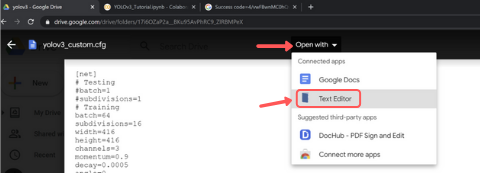

I recommend having **batch = 64** and **subdivisions = 16** for ultimate results. If you run into any issues then up subdivisions to 32.

Make the rest of the changes to the cfg based on how many classes you are training your detector on.

**Note:** I set my **max_batches = 10000**, **steps = 8000, 9000**, I changed the **classes = 5** in the three YOLO layers and **filters = 30** in the three convolutional layers before the YOLO layers. 

**Optional:** In each of the three yolo layers in the cfg, change one line from random = 1 to **random = 0** to speed up training but slightly reduce accuracy of model. Will also help save memory if you run into any memory issues.


In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/yolov4/yolov3_custom.cfg darknet/cfg

# upload the custom .cfg back to cloud VM from local machine (uncomment to use)
#%cd cfg
#upload()
#%cd .. 

## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** and you will make this file exactly the same as your classes.txt in the dataset generation step.

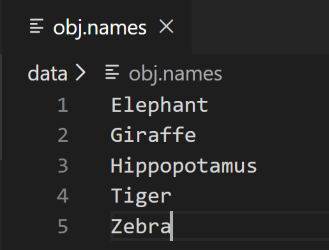

You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

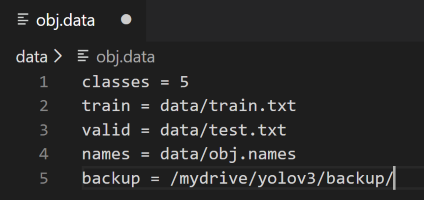



In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/yolov4/obj.names darknet/data
!cp /mydrive/yolov4/obj.data  darknet/data

# upload the obj.names and obj.data files to cloud VM from local machine (uncomment to use)
#%cd data
#upload()
#%cd .. 

## iii) Generating train.txt
The last configuration file needed before we can begin to train our custom detector is the train.txt file which hold the relative paths to all our training images.

Luckily I have created a script that I showed in a past video that generates train.txt for us.

The script can be accessed from this [Github Repo](https://github.com/theAIGuysCode/YoloGenerateTrainingFile/blob/master/generate_train.py/)

Just download the file to your local machine or Google drive so we can upload it to your cloud VM.

In [46]:
cd ..

/content


In [48]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/yolov4/generate_train.py darknet/
!cp /mydrive/yolov4/generate_test.py darknet/
# upload the generate_train.py script to cloud VM from local machine (uncomment to use)
#upload()


Now we simply run the python script to do all the work for us.

In [55]:
cd darknet/

/content/darknet


In [ ]:
!python generate_train.py

In [56]:
!python generate_test.py

In [57]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

9k.tree     giraffe.jpg		      labels		person.jpg  voc.names
coco9k.map  goal.txt		      obj		scream.jpg
coco.names  horses.jpg		      obj.data		test
dog.jpg     imagenet.labels.list      obj.names		test.txt
eagle.jpg   imagenet.shortnames.list  openimages.names	train.txt


If everything went as planned double click on **train.txt** on the left side File Explorer and it should look like this.
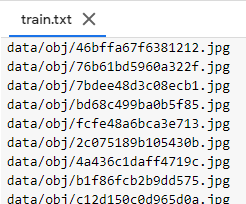

It will contain one line for each training image path.

# Step 4: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv3 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long. You don't have to use these weights but trust me it will help your modle converge and be accurate way faster. USE IT!

In [ ]:
!./darknet partial cfg/yolov3-tiny.cfg yolov3-tiny.weights yolov3-tiny.conv.15 15

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 GPU isn't used 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
   9 max                2x 2/ 2  

In [ ]:
ls

3rdparty/               darknet.py              net_cam_v4.sh*
backup/                 darknet_video.py        obj/
build/                  data/                   README.md
build.ps1*              generate_train.py       results/
build.sh*               image_yolov3.sh*        scripts/
cfg/                    image_yolov4.sh*        src/
cmake/                  include/                video_yolov3.sh*
CMakeLists.txt          json_mjpeg_streams.sh*  video_yolov4.sh*
darknet*                LICENSE                 yolov3-tiny.conv.15
DarknetConfig.cmake.in  Makefile                yolov3-tiny.weights
darknet_images.py       net_cam_v3.sh*


In [ ]:
# upload pretrained convolutional layer weights
# !wget http://pjreddie.com/media/files/darknet53.conv.74

# Step 5: Train Your Custom Object Detector!
The time has finally come! You have made it to the moment of truth! You are now ready to train your custom YOLOv3 object detector on whatever crazy classes you have decided on. So run the following command. (dont_show flag stops a chart from popping up since cloud can't open images on the spot)
```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```
**TIP:** This training could take several hours depending on how many iterations you chose in the .cfg file. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```
Looks like this, it will click the screen every 10 minutes so that you don't get kicked off for being idle! HACKS!

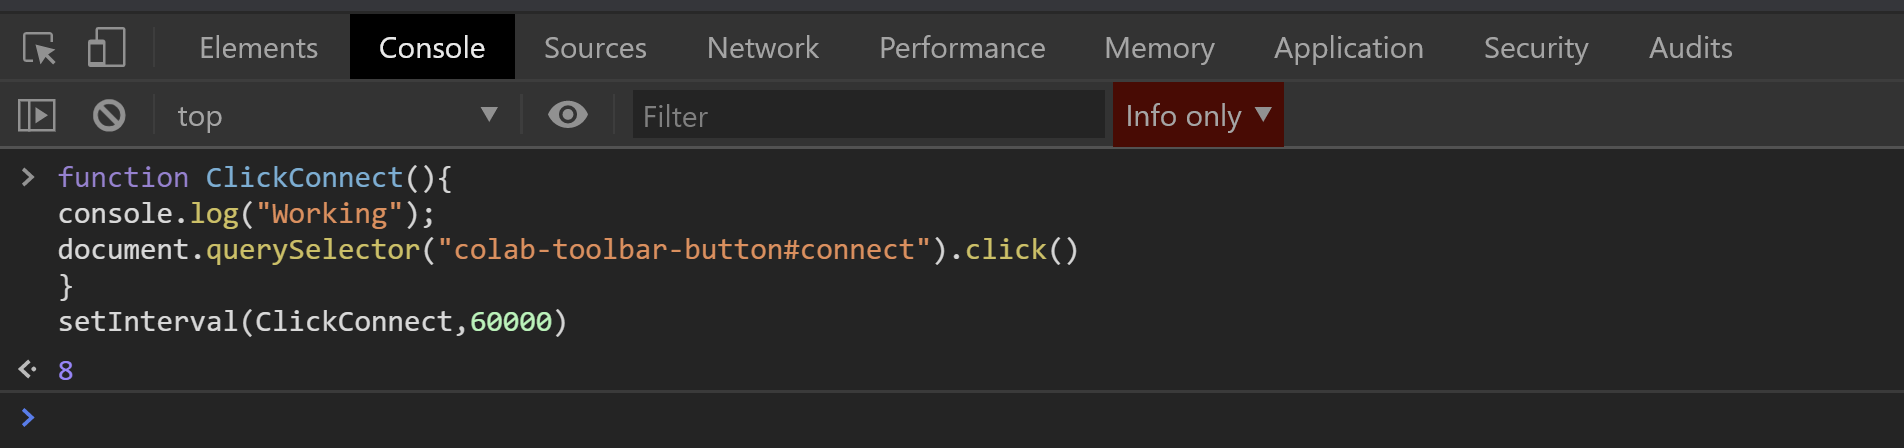

In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg yolov3-tiny.conv.15 -dont_show

Streaming output truncated to the last 5000 lines.
 4326: 1.029886, 1.250506 avg loss, 0.001000 rate, 0.554095 seconds, 276864 images, 0.566845 hours left
Loaded: 0.373556 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 16 Avg (IOU: 0.809035, GIOU: 0.807739), Class: 0.999060, Obj: 0.505998, No Obj: 0.005872, .5R: 1.000000, .75R: 0.750000, count: 4, class_loss = 0.385033, iou_loss = 0.101467, total_loss = 0.486500 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 23 Avg (IOU: 0.000000, GIOU: 0.000000), Class: 0.000000, Obj: 0.000000, No Obj: 0.000066, .5R: 0.000000, .75R: 0.000000, count: 1, class_loss = 0.001581, iou_loss = 0.000000, total_loss = 0.001581 
 total_bbox = 627740, rewritten_bbox = 0.685316 % 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 16 Avg (IOU: 0.732639, GIOU: 0.730688), Class: 0.999662, Obj: 0.513116, No Obj: 0.003621, .5R: 1.000000, .75R: 0.250000, count: 4, class_loss = 0.550440, iou

You can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you would aim for a loss under 2.

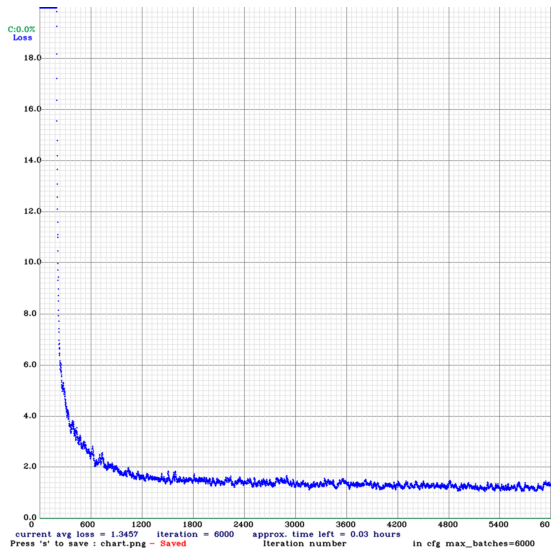

In [30]:
imShow('chart.png')

**TRICK**: If for some reason you get an error or your Colab goes idle during training, you have not lost your weights! Every 100 iterations a weights file called **yolov3_custom_last.weights** is saved to **mydrive/yolov3/backup/** folder (wherever your backup folder is). This is why we created this folder in our Google drive and not on the cloud VM. If your runtime crashes and your backup folder was in your cloud VM you would lose your weights and your training progress.

We can kick off training from our last saved weights file so that we don't have to restart! WOOHOO! Just run the following command but with your backup location.
```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [31]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov4/backup_y3/yolov3_custom_last.weights -dont_show

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
yolov3_custom
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x 

# Step 6: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections. Time to test it out and have some fun!

In [32]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


/content/darknet/cfg
/content/darknet


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   

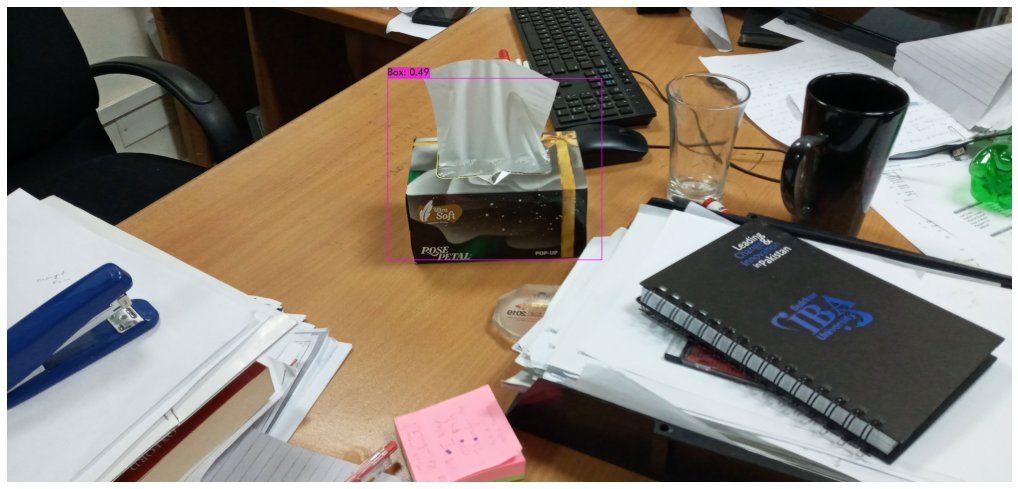

In [38]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov4/backup_y3/yolov3_custom_last.weights /mydrive/yolov4/20200830_170954.jpg -thresh 0.3
imShow('predictions.jpg')

In [58]:
!./darknet detector map data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov4/backup_y3/yolov3_custom_final.weights

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   

# Thanks!
Thanks for following along this tutorial, I hope it worked well for all of you!

If you enjoy YOLOv3 check out my other videos and subscribe to my channel so you don't miss out on any other amazing YOLOv3 content! 

[The AI Guy](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q)